# 3. Model tests
## 3.04 Example: GradientBoost

Process outline
1. Prepare time delay features
2. Spatial aggregation
   - Area weighted sum for precipitation features
   - Area mean for all other features
3. Define the model
4. Train the model
   - Reshape the input dataset to the model specific `X` and `y` arrays
   - Actually train on `X` and `y`

In [24]:
import sys
sys.path.append("../../")
print(sys.executable)
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import dask
dask.config.set(scheduler='threads')
import xarray as xr

from python.aux.utils_floodmodel import add_time, generate_prediction_array, remove_outlier, multi_forecast_case_study
from python.aux.plot import plot_multif_prediction

import joblib
from sklearn.pipeline import Pipeline
from dask_ml.preprocessing import StandardScaler
from dask_ml.decomposition import PCA

from sklearn.ensemble import GradientBoostingRegressor

import matplotlib
matplotlib.rcParams.update({'font.size': 14})

/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/bin/python3


## Loading the data
Sample dataset contained in the git repository.

As you are reading these lines, you opened the notebook in the `./docs/` folder of the main repository directory. To access the sample dataset that was delivered to you with the code, step outside the current directory (`../`) and enter the `data/` folder. The names of the sample datasets are `smallsampledata-era5.nc` and `smallsampledata-glofas.nc`, both in netCDF format, a user-friendly format that keeps the file size low and stores meta-data within the file.

We use `xarray` to access the files, as it provides us with a very powerful interface to work with the data.

The features are already prepared and ready to use, hence why they can be loaded directly from the `features_xy.nc` file.

Let's open the files and see what's in there:

In [2]:
# load data
features = xr.open_dataset('../../data/features_xy.nc')
y = features['dis']
X = features.drop(['dis', 'dis_diff'])

In [3]:
features

<xarray.Dataset>
Dimensions:     (time: 13514)
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2017-12-31
Data variables:
    cp          (time) float32 ...
    lsp         (time) float32 ...
    swvl1       (time) float32 ...
    ro          (time) float32 ...
    sd          (time) float32 ...
    sd_diff     (time) float32 ...
    lsp-4-11    (time) float32 ...
    lsp-12-25   (time) float32 ...
    lsp-26-55   (time) float32 ...
    lsp-56-180  (time) float32 ...
    lsp-1       (time) float32 ...
    lsp-2       (time) float32 ...
    lsp-3       (time) float32 ...
    cp-1        (time) float32 ...
    cp-2        (time) float32 ...
    cp-3        (time) float32 ...
    dis         (time) float64 ...
    dis_diff    (time) float64 ...

Some control parameters for the procedure:

 * `add_shift_switch`: Shift and add shifted values as new features for multi-day forecasts. (only needed if forecasting multiple days at once => currently only implemented with nns!)
 * `dis_shift_1`: Add the discharge from the last day as additional feature for testing purposes.
 * `abs_vals_switch`: Model is trained on absolute discharge values if True and on differences/change in discharge else.

In [4]:
dis_shift_switch = False

In [5]:
abs_vals_switch = False

Begin with some short preprocessing..

In [6]:
if dis_shift_switch:
    dis_shift_1 = y.shift(time=1)
    X = X.assign({'dis-1': dis_shift_1})

In [7]:
X_base = X.to_array(dim='features').T.copy()
y_base = y.copy()

Next, we split the dataset into three parts for 
- training (the longest period for estimating the free parameters within the model), 
- validation (for tuning hyperparameters) and 
- testing (for the model comparison).

In [8]:
period_train = dict(time=slice(None, '2005'))
period_valid = dict(time=slice('2006', '2011'))
period_test = dict(time=slice('2012', '2016'))

In [9]:
X_train, y_train = X_base.loc[period_train], y_base.loc[period_train]
X_valid, y_valid = X_base.loc[period_valid], y_base.loc[period_valid]
X_test, y_test = X_base.loc[period_test], y_base.loc[period_test]

In [10]:
X_train.shape, y_train.shape

((9131, 16), (9131,))

In [11]:
time = y_train.time
Xda = X_train.chunk(dict(time=-1, features=-1)).dropna(dim='time').to_pandas()

if abs_vals_switch:
    # train on absolute values
    yda = y_train.to_pandas().loc[Xda.index]
    # removing outlier and removing same parts from X
    yda = remove_outlier(yda)
    Xda = Xda.loc[yda.index]
else:
    # train on change in discharge values
    yda = y_train.diff(dim='time').to_pandas().loc[Xda.index]
    # removing outlier and removing same parts from X
    yda = remove_outlier(yda)
    Xda = Xda.loc[yda.index]

# Define boosting regressor

In [12]:
model = GradientBoostingRegressor(n_estimators=200,
                                  learning_rate=0.1,
                                  max_depth=5,
                                  random_state=0,
                                 # loss='ls'
                                 )

pipe = Pipeline([('scaler', StandardScaler()),
                 #('pca', PCA(n_components=6)),
                 ('model', model),], verbose=True)

X_fit = Xda.copy()
y_fit = yda.copy()
pipe.fit(X_fit, y_fit)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   4.5s


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse',
                                           init=None, learning_rate=0.1,
                                           loss='ls', max_depth=5,
                                           max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=200,
                                           n_iter_no_change=None,
                                      

### in sample test for the predicted change, to verify functionality

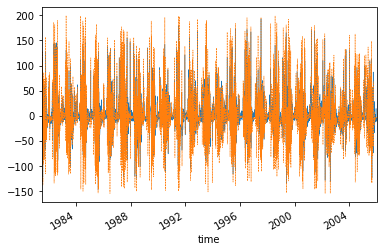

In [13]:
Xda_insample = Xda.copy()
insample_check = pipe.predict(Xda_insample)
insample_check = add_time(insample_check, Xda.index, name='forecast')
insample_check.to_pandas().plot(linewidth=0.5)
yda.plot(linestyle='--', linewidth=0.5)

Set the frequency at which forecast are started.

In [14]:
# prediction start from every nth day
# if in doubt, leave n = 1 !!!
n = 1
X_pred = X_valid[::n].copy()
y_pred = pipe.predict(X_pred)
y_pred = add_time(y_pred, X_pred.time, name='forecast')
print(y_pred)

<xarray.DataArray 'forecast' (time: 2191)>
array([  3.551498,  -3.019754,  -6.091677, ..., -12.928588,  -9.210042,
        -3.138835])
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2011-12-31


(<Figure size 1080x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd0d80da748>)

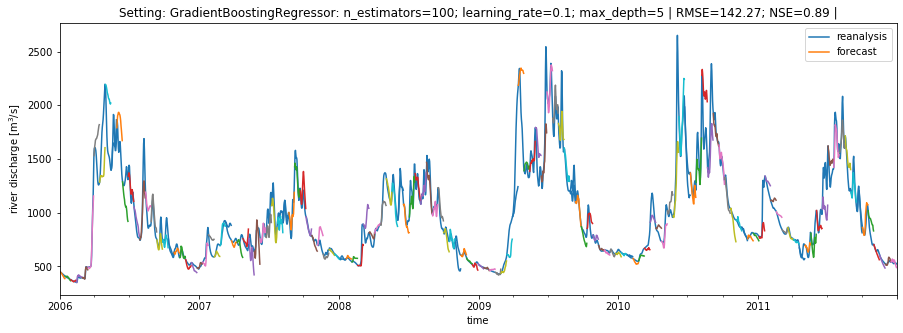

In [15]:
multif = generate_prediction_array(y_pred, y, forecast_range=14)
plot_multif_prediction(multif, y, forecast_range=14, title='Setting: GradientBoostingRegressor: n_estimators=100; learning_rate=0.1; max_depth=5')

#### Check the skill of a 14-day persistence forecast:

In [16]:
forecast_range = 14
y_o_pers = y_valid
# persistence
y_m_pers = y_valid.copy()
for i in range(1, forecast_range):
    y_m_pers.loc[y_valid.time[i::forecast_range]] = y_valid.shift(time=i)[i::forecast_range].values
    
rmse = np.sqrt(np.nanmean((y_m_pers - y_o_pers)**2))
nse = 1 - np.sum((y_m_pers - y_o_pers)**2)/(np.sum((y_o_pers - np.nanmean(y_o_pers))**2))
print(f"Persistence {forecast_range}-day forecast: RMSE={round(float(rmse), 2)}; NSE={round(float(nse.values), 2)}")

Persistence 14-day forecast: RMSE=210.1; NSE=0.75


Now, lets run a few different settings and compare the results:

|   n_estimators   |   learning_rate   |   max_depth   |   RMSE   |   NSE   | 
| :-----: | :-----: | :-----: | :-----: | :-----: |
| 10 | 0.05 | 1 | 197.41 | 0.8
| 10 | 0.05 | 2 | 191.4 | 0.81
| 10 | 0.05 | 3 | 186.96 | 0.82
| 10 | 0.05 | 4 | 182.56 | 0.83
| 10 | 0.05 | 5 | 179.38 | 0.83
| 10 | 0.05 | 6 | 177.28 | 0.84
| 10 | 0.05 | 7 | 174.66 | 0.84
| 10 | 0.05 | 8 | 174.55 | 0.84
| 10 | 0.05 | 9 | 172.26 | 0.85
| 10 | 0.05 | 10 | 172.66 | 0.84
| 10 | 0.05 | 15 | 172.41 | 0.85
| 10 | 0.1 | 1 | 192.42 | 0.81
| 10 | 0.1 | 2 | 183.21 | 0.83
| 10 | 0.1 | 3 | 176.93 | 0.84
| 10 | 0.1 | 4 | 170.17 | 0.85
| 10 | 0.1 | 5 | 164.83 | 0.86
| 10 | 0.1 | 6 | 162.34 | 0.86
| 10 | 0.1 | 7 | 160.55 | 0.87
| 10 | 0.1 | 8 | 158.55 | 0.87
| 10 | 0.1 | 9 | 155.32 | 0.87
| 10 | 0.1 | 10 | 158.16 | 0.87
| 10 | 0.1 | 15 | 159.2 | 0.87
| 10 | 0.2 | 1 | 184.54 | 0.82
| 10 | 0.2 | 2 | 173.02 | 0.84
| 10 | 0.2 | 3 | 165.05 | 0.86
| 10 | 0.2 | 4 | 156.02 | 0.87
| 10 | 0.2 | 5 | 148.13 | 0.89
| 10 | 0.2 | 6 | 147.61 | 0.89
| 10 | 0.2 | 7 | 147.86 | 0.89
| 10 | 0.2 | 8 | 149.23 | 0.88
| 10 | 0.2 | 9 | 147.06 | 0.89
| 10 | 0.2 | 10 | 148.5 | 0.89
| 10 | 0.2 | 15 | 156.15 | 0.87
| 50 | 0.05 | 1 | 183.64 | 0.82
| 50 | 0.05 | 2 | 170.91 | 0.85
| 50 | 0.05 | 3 | 160.38 | 0.87
| 50 | 0.05 | 4 | 151.42 | 0.88
| 50 | 0.05 | 5 | 148.28 | 0.89
| 50 | 0.05 | 6 | 143.87 | 0.89
| 50 | 0.05 | 7 | 144.23 | 0.89
| 50 | 0.05 | 8 | 144.34 | 0.89
| 50 | 0.05 | 9 | 143.31 | 0.89
| 50 | 0.05 | 10 | 146.82 | 0.89
| 50 | 0.05 | 15 | 154.26 | 0.88
| 50 | 0.1 | 1 | 174.74 | 0.84
| 50 | 0.1 | 2 | 159.71 | 0.87
| 50 | 0.1 | 3 | 149.85 | 0.88
| 50 | 0.1 | 4 | 144.3 | 0.89
| 50 | 0.1 | 5 | 138.97 | 0.9
| 50 | 0.1 | 6 | 137.74 | 0.9
| 50 | 0.1 | 7 | 140.0 | 0.9
| 50 | 0.1 | 8 | 139.16 | 0.9
| 50 | 0.1 | 9 | 137.93 | 0.9
| 50 | 0.1 | 10 | 143.03 | 0.89
| 50 | 0.1 | 15 | 149.84 | 0.88
| 50 | 0.2 | 1 | 164.16 | 0.86
| 50 | 0.2 | 2 | 151.27 | 0.88
| 50 | 0.2 | 3 | 142.9 | 0.89
| 50 | 0.2 | 4 | 138.33 | 0.9
| 50 | 0.2 | 5 | 134.79 | 0.91
| 50 | 0.2 | 6 | 135.02 | 0.91
| 50 | 0.2 | 7 | 138.22 | 0.9
| 50 | 0.2 | 8 | 141.83 | 0.9
| 50 | 0.2 | 9 | 142.36 | 0.89
| 50 | 0.2 | 10 | 145.87 | 0.89
| 50 | 0.2 | 15 | 154.06 | 0.88
| 100 | 0.05 | 1 | 174.64 | 0.84
| 100 | 0.05 | 2 | 159.49 | 0.87
| 100 | 0.05 | 3 | 149.45 | 0.88
| 100 | 0.05 | 4 | 143.9 | 0.89
| 100 | 0.05 | 5 | 142.6 | 0.89
| 100 | 0.05 | 6 | 138.71 | 0.9
| 100 | 0.05 | 7 | 138.71 | 0.9
| 100 | 0.05 | 8 | 138.71 | 0.9
| 100 | 0.05 | 9 | 138.82 | 0.9
| 100 | 0.05 | 10 | 144.49 | 0.89
| 100 | 0.05 | 15 | 153.45 | 0.88
| 100 | 0.1 | 1 | 164.5 | 0.86
| 100 | 0.1 | 2 | 151.08 | 0.88
| 100 | 0.1 | 3 | 144.4 | 0.89
| 100 | 0.1 | 4 | 138.96 | 0.9
| 100 | 0.1 | 5 | 134.78 | 0.91
| 100 | 0.1 | 6 | 136.1 | 0.9
| 100 | 0.1 | 7 | 137.61 | 0.9
| 100 | 0.1 | 8 | 139.74 | 0.9
| 100 | 0.1 | 9 | 137.71 | 0.9
| 100 | 0.1 | 10 | 142.99 | 0.89
| 100 | 0.1 | 15 | 149.7 | 0.88
| 100 | 0.2 | 1 | 157.8 | 0.87
| 100 | 0.2 | 2 | 143.58 | 0.89
| 100 | 0.2 | 3 | 139.44 | 0.9
| 100 | 0.2 | 4 | 134.87 | 0.91
| 100 | 0.2 | 5 | 135.05 | 0.91
| 100 | 0.2 | 6 | 137.64 | 0.9
| 100 | 0.2 | 7 | 140.04 | 0.9
| 100 | 0.2 | 8 | 143.09 | 0.89
| 100 | 0.2 | 9 | 142.28 | 0.89
| 100 | 0.2 | 10 | 146.57 | 0.89
| 100 | 0.2 | 15 | 154.05 | 0.88
| 200 | 0.05 | 1 | 164.87 | 0.86
| 200 | 0.05 | 2 | 152.16 | 0.88
| 200 | 0.05 | 3 | 142.79 | 0.89
| 200 | 0.05 | 4 | 138.14 | 0.9
| 200 | 0.05 | 5 | 138.43 | 0.9
| 200 | 0.05 | 6 | 136.48 | 0.9
| 200 | 0.05 | 7 | 138.23 | 0.9
| 200 | 0.05 | 8 | 138.28 | 0.9
| 200 | 0.05 | 9 | 139.87 | 0.9
| 200 | 0.05 | 10 | 144.69 | 0.89
| 200 | 0.05 | 15 | 153.36 | 0.88
| 200 | 0.1 | 1 | 157.82 | 0.87
| 200 | 0.1 | 2 | 144.66 | 0.89
| 200 | 0.1 | 3 | 141.22 | 0.9
| 200 | 0.1 | 4 | 137.15 | 0.9
| 200 | 0.1 | 5 | 133.82 | 0.91
| 200 | 0.1 | 6 | 138.13 | 0.9
| 200 | 0.1 | 7 | 138.65 | 0.9
| 200 | 0.1 | 8 | 141.09 | 0.9
| 200 | 0.1 | 9 | 139.26 | 0.9
| 200 | 0.1 | 10 | 143.66 | 0.89
| 200 | 0.1 | 15 | 149.71 | 0.88
| 200 | 0.2 | 1 | 153.71 | 0.88
| 200 | 0.2 | 2 | 138.05 | 0.9
| 200 | 0.2 | 3 | 136.03 | 0.9
| 200 | 0.2 | 4 | 135.36 | 0.9
| 200 | 0.2 | 5 | 134.0 | 0.91
| 200 | 0.2 | 6 | 137.15 | 0.9
| 200 | 0.2 | 7 | 141.61 | 0.9
| 200 | 0.2 | 8 | 144.21 | 0.89
| 200 | 0.2 | 9 | 143.23 | 0.89
| 200 | 0.2 | 10 | 146.42 | 0.89
| 200 | 0.2 | 15 | 154.05 | 0.88
| 300 | 0.05 | 1 | 160.46 | 0.87
| 300 | 0.05 | 2 | 149.26 | 0.88
| 300 | 0.05 | 3 | 139.02 | 0.9
| 300 | 0.05 | 4 | 135.69 | 0.9
| 300 | 0.05 | 5 | 137.48 | 0.9
| 300 | 0.05 | 6 | 137.36 | 0.9
| 300 | 0.05 | 7 | 138.74 | 0.9
| 300 | 0.05 | 8 | 138.99 | 0.9
| 300 | 0.05 | 9 | 140.68 | 0.9
| 300 | 0.05 | 10 | 145.11 | 0.89
| 300 | 0.05 | 15 | 153.36 | 0.88
| 300 | 0.1 | 1 | 155.08 | 0.87
| 300 | 0.1 | 2 | 141.91 | 0.9
| 300 | 0.1 | 3 | 140.15 | 0.9
| 300 | 0.1 | 4 | 137.32 | 0.9
| 300 | 0.1 | 5 | 135.07 | 0.91
| 300 | 0.1 | 6 | 139.13 | 0.9
| 300 | 0.1 | 7 | 139.98 | 0.9
| 300 | 0.1 | 8 | 141.96 | 0.9
| 300 | 0.1 | 9 | 139.77 | 0.9
| 300 | 0.1 | 10 | 143.77 | 0.89
| 300 | 0.1 | 15 | 149.71 | 0.88
| 300 | 0.2 | 1 | 151.95 | 0.88
| 300 | 0.2 | 2 | 136.59 | 0.9
| 300 | 0.2 | 3 | 136.9 | 0.9
| 300 | 0.2 | 4 | 136.49 | 0.9
| 300 | 0.2 | 5 | 136.17 | 0.9
| 300 | 0.2 | 6 | 137.85 | 0.9
| 300 | 0.2 | 7 | 141.37 | 0.9
| 300 | 0.2 | 8 | 144.67 | 0.89
| 300 | 0.2 | 9 | 143.41 | 0.89
| 300 | 0.2 | 10 | 146.37 | 0.89
| 300 | 0.2 | 15 | 154.05 | 0.88
| --------------- | --------------- | --------------- | --------------- | --------------- |
| persistence 14-day forecast |  |  | 251.09 | 0.77 |



Concluding, the best setting is  `n_estimators=200`, `learning_rate=0.1` and `max_depth=5`, although, as already mentioned, the differences between on the upper end is quite marginal and hence, is not that critical to small deviations. As can be seen, the model is baseline better than the persistence, no matter the setting, which shows that there is at least some skill in using it. It should also be noted, that the persistence forecast for such an application is in general not that bad, because absolute values of discharge are validated and the day-to-day change is usually one magnitude lower than the absoluate value, resulting in quite a good skill for the persistence forecast (the major exception being strong flooging events, where most of the time long periods of precipitation lead to day-to-day changes of the possibly almost the same order of magnitude as the absolute values.

## Prediction for the test data (used in the model evaluation notebook for comparison)
Note that the optimized model setting is already updated in the model call far above.

(<Figure size 1080x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd0d01bbe48>)

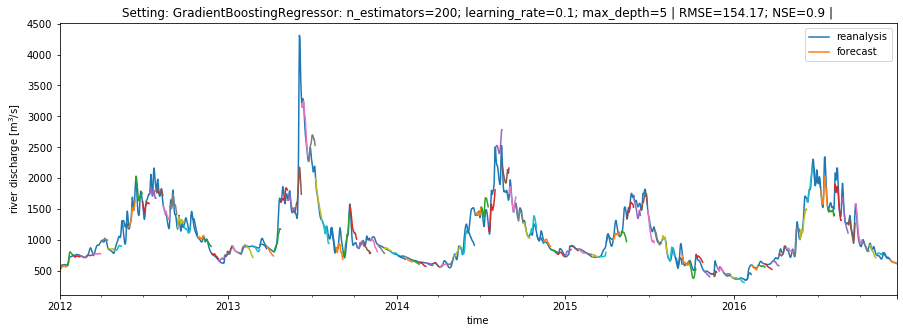

In [17]:
# prediction start from every nth day
# if in doubt, leave n = 1 !!!
n = 1
X_pred = X_test[::n].copy()
y_pred = pipe.predict(X_pred)
y_pred = add_time(y_pred, X_pred.time, name='forecast')

multif_test = generate_prediction_array(y_pred, y, forecast_range=14)
plot_multif_prediction(multif_test, y, forecast_range=14, title='Setting: GradientBoostingRegressor: n_estimators=200; learning_rate=0.1; max_depth=5')

## Case study: May/June 2013; Flooding event at Krems (Danube river)

Drop long time feature not available for the period of interest and do the same preparation steps as before.

In [18]:
X_multif_fin, X_multifr_fin, y_case_fin = multi_forecast_case_study(pipe, X_test, y)

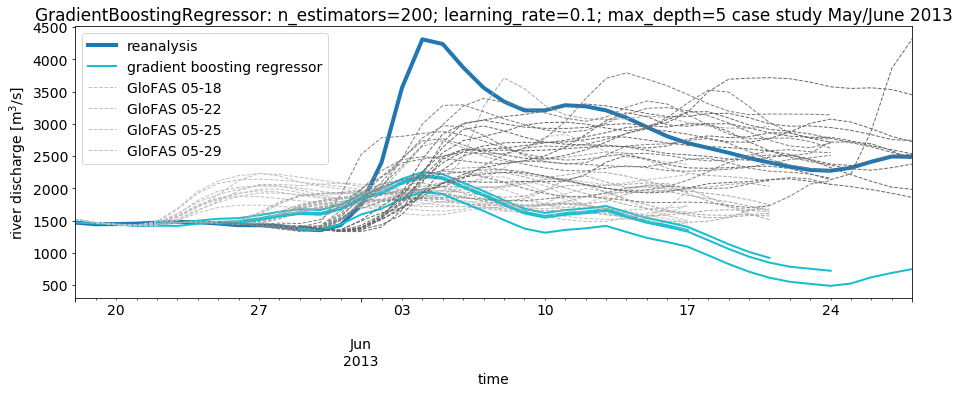

In [25]:
fig, ax = plt.subplots(figsize=(15, 5))
frerun_c = ['silver', 'darkgray', 'gray', 'dimgray']

y_case_fin.to_pandas().plot(ax=ax, label='reanalysis', linewidth=4)
run = 0
for i in X_multifr_fin.num_of_forecast:
    X_multif_fin.sel(num_of_forecast=i).to_pandas().T.plot(ax=ax, label='forecast',
                                                           linewidth=2, color='tab:cyan')
    X_multifr_fin.sel(num_of_forecast=i).to_pandas().T.plot(ax=ax, label='frerun', linewidth=1,
                                                            linestyle='--', color=frerun_c[run])
    run += 1
ax.set_ylabel('river discharge [m$^3$/s]')
plt.legend(['reanalysis', 'gradient boosting regressor', 'GloFAS 05-18', 'GloFAS 05-22', 'GloFAS 05-25', 'GloFAS 05-29'])
plt.title('GradientBoostingRegressor: n_estimators=200; learning_rate=0.1; max_depth=5 case study May/June 2013');
plt.savefig('gradboost_case.png', dpi=600, bbox_inches='tight')

Save the postprocessed model forecast, as well as the forecast rerun and the reanalysis data.

In [21]:
X_multif_fin.to_netcdf('../../data/models/GradientBoost/gradient_boost_result_case_study.nc', mode='w')

Save data of the test period for the model comparison.

In [23]:
multif_test.to_netcdf('../../data/models/GradientBoost/gradient_boost_result_test_period.nc', mode='w')